In [285]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt


In [286]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal, sr=None):
    plt.figure(figsize=(7,2))
    return librosa.display.waveshow(signal, sr=sr)

## Data preprocessing for helloworld.wav (testing, optional to run)

In [287]:
sample0, sr0 = librosa.load("wav/test/Hello World 2.wav")


In [288]:
sr0

22050

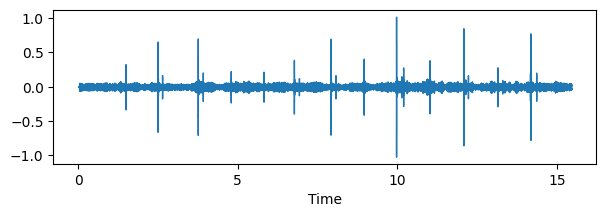

In [289]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(sample0, sr=sr0)

In [290]:
# Unified parameters (run this once)
n_fft = 1024
hop_length = 256
before = 2400
after = 5000

# threshold percentile used inside isolator when threshold=None
threshold_percentile = 96

# 최소 키 누르기 간격 (초 단위) - 동시 타이핑 고려
min_keystroke_gap = 0.03  # 50ms (손가락 2개 겹침 허용), 필요시 0.03~0.1로 조정

# band-limited energy for keystroke detection
band_fmin = 1000
band_fmax = 19000


In [291]:
#Calculating the STFT of the Sample
fft = librosa.stft(sample0, n_fft = n_fft , hop_length = hop_length)

In [292]:
#Calculating the Energy of the Signal using FFT
#energy = np.abs(np.sum(fft, axis=0)).astype(float)
energy = np.sum(np.abs(fft)**2, axis=0)   # power 합 (표준)


In [293]:
len(energy), len(sample0), len(fft)

(1331, 340570, 513)

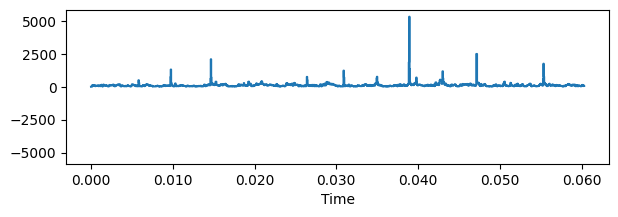

In [294]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(energy)

In [295]:
# (Removed manual energy/threshold for sample0)
# Use isolator(sample0, ...) below to keep behavior identical to batch processing.


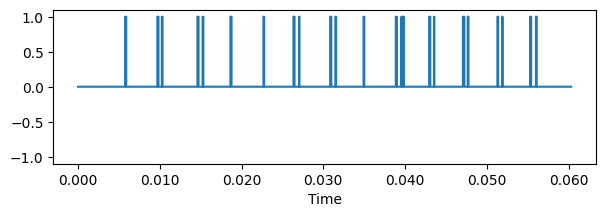

In [296]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(threshed.astype(float))

In [297]:
peaks = np.where(threshed == True)[0]
print(peaks)


[ 127  128  129  214  215  216  226  227  322  323  324  336  337  411
  412  413  500  501  581  582  583  596  680  681  682  694  695  770
  771  857  858  859  872  876  877  878  947  948  949  960 1038 1039
 1040 1041 1051 1052 1131 1132 1144 1219 1220 1221 1235 1236]


In [298]:
peak_count = len(peaks)
print(peak_count)

54


In [299]:
prev_end = sr0*0.1*(-1)

In [300]:
strokes = []
stroke_times = []  # IKI 계산을 위해 타이밍 기록

In [301]:
# Use isolator for sample0 to match batch processing
strokes = []
stroke_times = []
strokes, stroke_times = isolator(
    sample0, sr0, n_fft, hop_length, before, after, threshold=None, show=False,
    band_fmin=band_fmin, band_fmax=band_fmax
)
print('strokes:', len(strokes))


peaks: 54
strokes: 13
strokes: 13


In [302]:
strokes

[array([-0.03177923, -0.02981675, -0.02855608, ..., -0.01283904,
        -0.01379711, -0.01419256], shape=(7400,), dtype=float32),
 array([-0.01491894, -0.0126581 , -0.00916057, ..., -0.02358126,
        -0.02359007, -0.02296495], shape=(7400,), dtype=float32),
 array([ 0.01080514,  0.00850282,  0.00718641, ..., -0.02643794,
        -0.02604947, -0.02454583], shape=(7400,), dtype=float32),
 array([ 0.01732436,  0.01815676,  0.01752819, ..., -0.00313837,
        -0.00175483,  0.00080251], shape=(7400,), dtype=float32),
 array([0.00404594, 0.0039549 , 0.00430742, ..., 0.00902984, 0.01051289,
        0.01077914], shape=(7400,), dtype=float32),
 array([-0.00335298, -0.0062538 , -0.00644387, ..., -0.01732785,
        -0.01767023, -0.01717838], shape=(7400,), dtype=float32),
 array([-0.00356447, -0.00590806, -0.00851917, ...,  0.04510849,
         0.04765795,  0.0482565 ], shape=(7400,), dtype=float32),
 array([-0.0262952 , -0.02729973, -0.02754829, ..., -0.00996909,
        -0.00917415, -0.

In [303]:
print("peaks:", len(peaks))
print("strokes:", len(strokes))


peaks: 54
strokes: 13


In [304]:
iki = np.diff(stroke_times)
print(f"Stroke count: {len(stroke_times)}")
print(f"IKI (초): {iki}")
print(f"IKI (ms): {iki * 1000}")


print("stroke_times:", stroke_times)

if len(stroke_times) < 2:
    print("=> stroke_times가 2개 미만입니다. isolator/peaks 확인 필요.")
else:
    iki = np.diff(np.array(stroke_times))
    
    short_idx = np.where(iki < 0.4)[0]
    

   
    for i in short_idx:
        print(i, stroke_times[i], stroke_times[i+1], iki[i])
        start = int(max(0, (stroke_times[i]-0.1)*sr0))
        end = int(min(len(sample0), (stroke_times[i+1]+0.1)*sr0))
        plt.figure(figsize=(8,2))
        disp_waveform(sample0[start:end], sr=sr0)
        plt.show()

Stroke count: 13
IKI (초): [1.01006803 1.25387755 1.03328798 1.03328798 0.94040816 1.14938776
 1.04489796 1.01006803 1.04489796 1.05650794 1.07972789 1.021678  ]
IKI (ms): [1010.06802721 1253.87755102 1033.28798186 1033.28798186  940.40816327
 1149.3877551  1044.89795918 1010.06802721 1044.89795918 1056.50793651
 1079.72789116 1021.67800454]
stroke_times: [np.float64(1.497687074829932), np.float64(2.507755102040816), np.float64(3.7616326530612243), np.float64(4.794920634920635), np.float64(5.828208616780046), np.float64(6.768616780045352), np.float64(7.918004535147392), np.float64(8.962902494331066), np.float64(9.97297052154195), np.float64(11.017868480725623), np.float64(12.07437641723356), np.float64(13.154104308390023), np.float64(14.17578231292517)]


In [305]:
spect = librosa.feature.melspectrogram(y=np.asarray(strokes[0]), n_mels=64, hop_length=225)


In [306]:
def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold=None, show=False,
             band_fmin=None, band_fmax=None):
    strokes = []
    stroke_times = []
    # -- signal'
    if show:
        disp_waveform(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

    # band-limited energy (optional)
    if band_fmin is not None or band_fmax is not None:
        freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
        if band_fmin is None:
            band_fmin = 0
        if band_fmax is None:
            band_fmax = freqs[-1]
        band_mask = (freqs >= band_fmin) & (freqs <= band_fmax)
        energy = np.sum(np.abs(fft[band_mask])**2, axis=0)
    else:
        energy = np.sum(np.abs(fft)**2, axis=0)   # power 합 (표준)

    # threshold auto from same signal unless provided
    if threshold is None:
        threshold = np.percentile(energy, threshold_percentile)
    # -- energy'
    if show:
        disp_waveform(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(keystroke)
            stroke_times.append(timestamp / sample_rate)
            if show:
                disp_waveform(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    print("peaks:", len(peaks))
    print("strokes:", len(strokes))
    
    return strokes, stroke_times


In [307]:
def create_dataset(n_fft, hop_length, before, after):
    for i, File in enumerate(keys):
        loc = MBP_AUDIO_DIR + File
        samples, sr = librosa.load(loc, sr=None)
        # samples, sr = librosa.load(loc,sr=None,duration=1.0,mono=True)

        strokes = []
        thr = np.percentile(energy, 97) 
        step = 0.005
        strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, thr, False, band_fmin=band_fmin, band_fmax=band_fmax )
        # while not len(strokes) == 25:
        #   strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, prom, False )
        #   if len(strokes) < 25:
        #     prom -= step
        #   if len(strokes) > 25:
        #     prom += step
        #   if prom < 0:
        #     print("--not possible for : ", File)
        #     break
        #   step = step * 0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)

    return df

## Generating MelSpectrograms

In [308]:
# --- Feature extractor setup ---
import numpy as np
import torch
from feature_extraction import CoAtNet

# If you have pretrained weights, set path here; otherwise it will use random weights.
weights_path = None  # e.g., 'coatnet_weights.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CoAtNet().to(device)
if weights_path:
    state = torch.load(weights_path, map_location=device)
    model.load_state_dict(state)
model.eval()


CoAtNet(
  (s0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
  )
  (s1): MBConv(
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (proj): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): SE(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_featu

In [309]:
# --- Mel -> 768 feature ---
import librosa
import librosa.display
import torch.nn.functional as F

@torch.no_grad()
def extract_feature_from_wave(wave, sr):
    mel = librosa.feature.melspectrogram(y=wave, sr=sr, n_mels=64, n_fft=1024, hop_length=225)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # normalize to 0..1
    mel_min, mel_max = mel_db.min(), mel_db.max()
    mel_norm = (mel_db - mel_min) / (mel_max - mel_min + 1e-8)

    # to 3-channel tensor [1,3,H,W]
    img = np.stack([mel_norm, mel_norm, mel_norm], axis=0)  # [3,H,W]
    img_t = torch.from_numpy(img).unsqueeze(0).float().to(device)

    # resize to 224x224
    img_t = F.interpolate(img_t, size=(224, 224), mode='bilinear', align_corners=False)

    # normalize (ImageNet stats)
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    img_t = (img_t - mean) / std

    feat = model(img_t).squeeze(0).cpu().numpy()  # [768]
    return feat


In [ ]:
# --- Process wav files: strokes -> mel images -> NPZ ---
from pathlib import Path
import matplotlib.pyplot as plt

test_dir = Path('wav')
out_root = Path('out/test')
out_root.mkdir(parents=True, exist_ok=True)

npz_dir = Path('npz_sequences')
npz_dir.mkdir(parents=True, exist_ok=True)

# sample-style parameters
before = 2400 #2400
after = 5000 #5000

for wav_path in sorted(test_dir.rglob('*.wav')):
    rel = wav_path.relative_to(test_dir)
    rel_dir = rel.parent
    key = wav_path.stem
    samples, sr = librosa.load(wav_path.as_posix())

    print('file:', wav_path.name)
    print('sr:', sr, 'len:', len(samples))
    print('n_fft:', n_fft, 'hop:', hop_length, 'before:', before, 'after:', after)

    # isolate keystrokes with auto-threshold on the same signal
    strokes, stroke_times = isolator(samples, sr, n_fft, hop_length, before, after, threshold=None, show=False,
                                     band_fmin=band_fmin, band_fmax=band_fmax)

    # save mel images
    key_out = out_root / rel_dir / key
    key_out.mkdir(parents=True, exist_ok=True)
    for i, stroke in enumerate(strokes):
        mel = librosa.feature.melspectrogram(
            y=np.asarray(stroke).squeeze(),
            sr=sr,
            n_mels=64,
            n_fft=1024,
            hop_length=225,
        )
        plt.figure(figsize=(6, 4))
        librosa.display.specshow(
            librosa.power_to_db(mel, ref=np.max),
            x_axis='time',
            y_axis='mel',
            sr=sr,
            hop_length=225,
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram ({key}) - keystroke {i}')
        plt.tight_layout()
        plt.savefig(key_out / f'keystroke_{i:04d}.png', dpi=150)
        plt.close()

    # build IKI (seconds) and features
    if len(stroke_times) >= 2:
        iki = np.diff(np.array(stroke_times, dtype=float))
    else:
        iki = np.array([], dtype=float)

    features = []
    for stroke in strokes:
        feat = extract_feature_from_wave(np.asarray(stroke).squeeze(), sr)
        features.append(feat)

    x = np.stack(features, axis=0) if features else np.zeros((0, 768), dtype=float)

    # label string from filename: key_<label>.wav
    label_str = key
    if label_str.startswith('key_'):
        label_str = label_str[len('key_'):]

    out_npz = npz_dir / f'key_{label_str}.npz'
    np.savez(out_npz, x=x, iki=iki)
    print('Saved npz:', out_npz)


file: ,.wav
sr: 22050 len: 2776772
n_fft: 1024 hop: 256 before: 2000 after: 10000
peaks: 434
strokes: 114
Saved npz: npz_sequences/key_,.npz
file: 0.wav
sr: 22050 len: 2822400
n_fft: 1024 hop: 256 before: 2000 after: 10000
peaks: 441
strokes: 118
Saved npz: npz_sequences/key_0.npz
file: 1.wav
sr: 22050 len: 2731613
n_fft: 1024 hop: 256 before: 2000 after: 10000
peaks: 427
strokes: 107
Saved npz: npz_sequences/key_1.npz
file: 2.wav
sr: 22050 len: 2773008
n_fft: 1024 hop: 256 before: 2000 after: 10000
peaks: 434
strokes: 121
Saved npz: npz_sequences/key_2.npz
file: 3.wav
sr: 22050 len: 2842157
n_fft: 1024 hop: 256 before: 2000 after: 10000
peaks: 445
strokes: 127
Saved npz: npz_sequences/key_3.npz
file: 4.wav
sr: 22050 len: 2659172
n_fft: 1024 hop: 256 before: 2000 after: 10000
peaks: 416
strokes: 118
Saved npz: npz_sequences/key_4.npz
file: 5.wav
sr: 22050 len: 2693511
n_fft: 1024 hop: 256 before: 2000 after: 10000
peaks: 421
strokes: 112
Saved npz: npz_sequences/key_5.npz
file: 6.wav
s

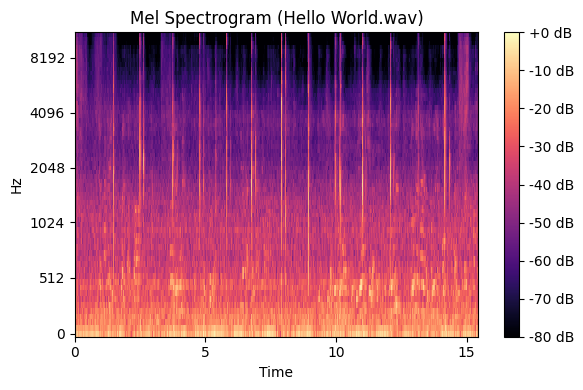

In [311]:
# Mel-spectrogram image for Hello World 2.wav
import matplotlib.pyplot as plt
import librosa.display
sample_hw2, sr_hw2 = librosa.load("wav/test/Hello World 2.wav")
mel_hw2 = librosa.feature.melspectrogram(
    y=sample_hw2, sr=sr_hw2, n_mels=64, n_fft=1024, hop_length=225
)
plt.figure(figsize=(6, 4))
librosa.display.specshow(librosa.power_to_db(mel_hw2, ref=np.max), x_axis='time', y_axis='mel', sr=sr_hw2, hop_length=225)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (Hello World.wav)')
plt.tight_layout()
plt.show()
